# Bayesian Regression Using Pyro

In this tutorial, we will explore how to do bayesian regression in Pyro, using a simple example adapted from Statistical Rethinking [[1](#References)]. In particular, we would like to explore the following:

- Write a simple model using the sample Pyro primitive.
- Run inference using MCMC in Pyro, in particular, using the No U-Turn Sampler (NUTS) to get a posterior distribution over our regression parameters of interest. We also show an example of inference using Pyro's SVI.
- Learn about inference utilities such as `Predictive` and `log_likelihood`.
- Learn how we can use effect-handlers in Pyro to generate execution traces from the model, condition on sample statements, etc., and use this to implement various utilities that will be useful for MCMC. e.g. computing model log likelihood, generating empirical distribution over the posterior predictive, etc.

## Tutorial Outline:

1. [Dataset](#Dataset)
2. [Regression Model to Predict Divorce Rate](#Regression-Model-to-Predict-Divorce-Rate)
    - [Model-1: Predictor-Marriage Rate](#Model-1:-Predictor---Marriage-Rate)
       - [Posterior Distribution over the Regression Parameters](#Posterior-Distribution-over-the-Regression-Parameters)
       - [Prior Predictive Distribution](#Prior-Predictive-Distribution)
       - [Posterior Predictive Distribution](#Posterior-Predictive-Distribution)
       - [Predictive Utility With Effect Handlers](#Predictive-Utility-With-Effect-Handlers)
       - [Model Predictive Density](#Model-Predictive-Density)
       - [Regression with Pyro's Stochastic Variational Inference (SVI)](#SVI)
    - [Model-2: Predictor-Median Age of Marriage](#Model-2:-Predictor---Median-Age-of-Marriage)
    - [Model-3: Predictor-Marriage Rate and Median Age of Marriage](#Model-3:-Predictor---Marriage-Rate-and-Median-Age-of-Marriage)
    - [Divorce Rate Residuals by State](#Divorce-Rate-Residuals-by-State)
3. [Regression Model with Measurement Error](#Regression-Model-with-Measurement-Error)
    - [Effect of Incorporating Measurement Noise on Residuals](#Effect-of-Incorporating-Measurement-Noise-on-Residuals)
4. [References](#References)


In [1]:
import os

from IPython.display import set_matplotlib_formats
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from functorch import vmap as vmap
from torch import logsumexp

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim as optim
from pyro.infer import HMC, NUTS, MCMC
import pyro.ops.stats as stats

plt.style.use("bmh")

assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(1)

## <a id='Dataset'>Dataset</a>

For this example, we will use the WaffleDivorce dataset from Chapter 05, Statistical Rethinking [[1](#References)]. The dataset contains divorce rates in each of the 50 states in the USA, along with predictors such as population, median age of marriage, whether it is a Southern state and, curiously, number of Waffle Houses.

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


Let us plot the pair-wise relationship amongst the main variables in the dataset, using `seaborn.pairplot`. 

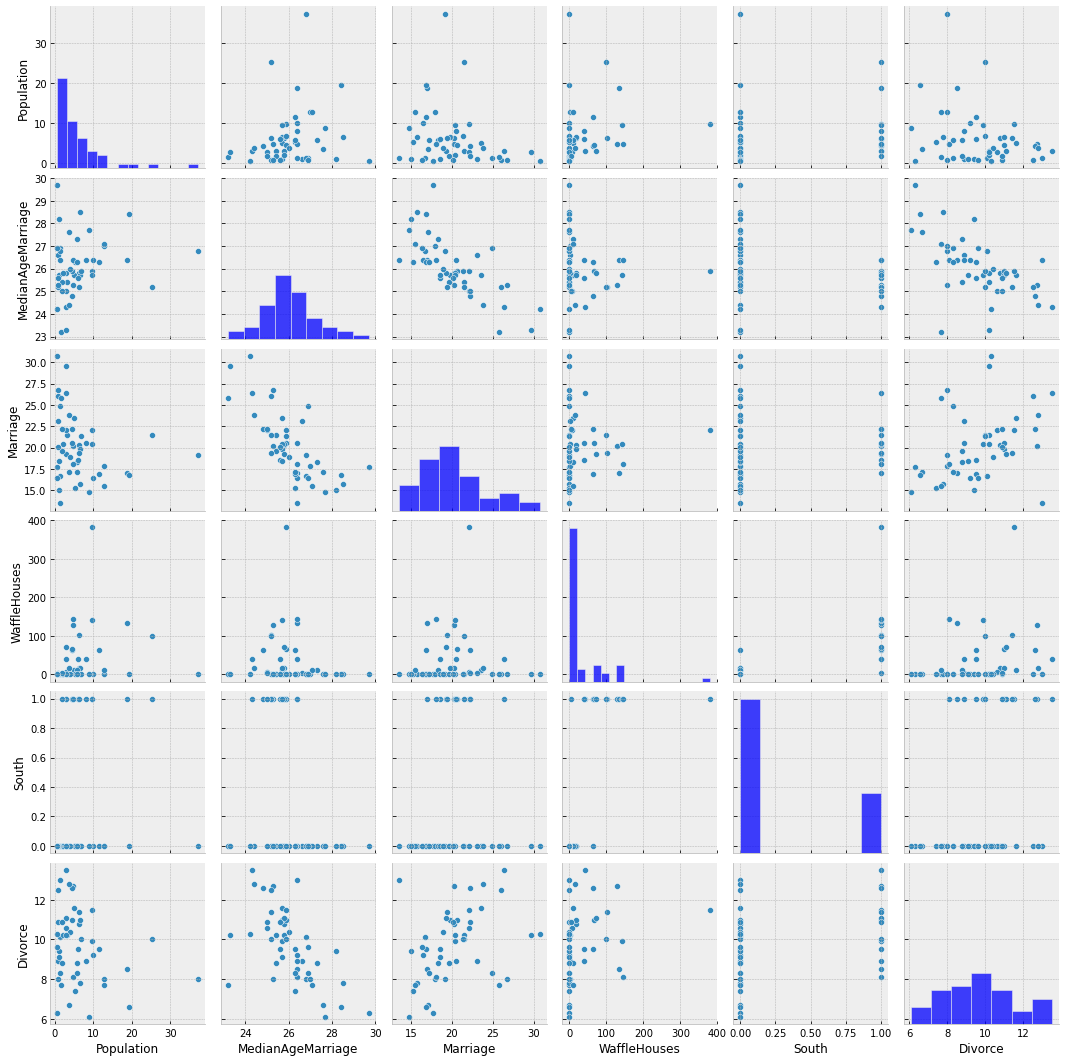

In [3]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl");

From the plots above, we can clearly observe that there is a relationship between divorce rates and marriage rates in a state (as might be expected), and also between divorce rates and median age of marriage.

There is also a weak relationship between number of Waffle Houses and divorce rates, which is not obvious from the plot above, but will be clearer if we regress `Divorce` against `WaffleHouse` and plot the results.

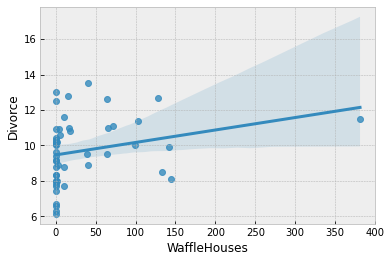

In [4]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);

This is an example of a spurious association. We do not expect the number of Waffle Houses in a state to affect the divorce rate, but it is likely correlated with other factors that have an effect on the divorce rate. We will not delve into this spurious association in this tutorial, but the interested reader is encouraged to read Chapters 5 and 6 of [[1](#References)] which explores the problem of causal association in the presence of multiple predictors.


For simplicity, we will primarily focus on marriage rate and the median age of marriage as our predictors for divorce rate throughout the remaining tutorial.


## <a id='#Regression-Model-to-Predict-Divorce-Rate'>Regression Model to Predict Divorce Rate</a>


Let us now write a regression model in *Pyro* to predict the divorce rate as a linear function of marriage rate and median age of marriage in each of the states.

First, note that our predictor variables have somewhat different scales. It is a good practice to standardize our predictors and response variables to mean `0` and standard deviation `1`, which should result in [faster inference](https://mc-stan.org/docs/2_19/stan-users-guide/standardizing-predictors-and-outputs.html).

In [5]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

We write the Pyro model as follows. While the code should largely be self-explanatory, take note of the following:

- In Pyro, model code is any Python callable which can optionally accept additional arguments and keywords. For HMC which we will be using for this tutorial, these arguments and keywords remain static during inference, but we can reuse the same model to generate [predictions](#Posterior-Predictive-Distribution) on new data.
- In addition to regular Python statements, the model code also contains primitives like `sample`. These primitives can be interpreted with various side-effects using effect handlers. For more on effect handlers, refer to [[3](#References)], [[4](#References)]. For now, just remember that a `sample` statement makes this a stochastic function that samples some latent parameters from a *prior distribution*. Our goal is to infer the *posterior distribution* of these parameters conditioned on observed data.
- The reason why we have kept our predictors as optional keyword arguments is to be able to reuse the same model as we vary the set of predictors. Likewise, the reason why the response variable is optional is that we would like to reuse this model to sample from the posterior predictive distribution. See the [section](#Posterior-Predictive-Distribution) on plotting the posterior predictive distribution, as an example.



In [6]:
def model(marriage=None, age=None, divorce=None):
    a = pyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if age is not None:
        bA = pyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    if marriage is not None:
        bM = pyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    sigma = pyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    pyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

### <a id='Model-1:-Predictor---Marriage-Rate'>Model 1: Predictor - Marriage Rate</a>


We first try to model the divorce rate as depending on a single variable, marriage rate. As mentioned above, we can use the same `model` code as earlier, but only pass values for `marriage` and `divorce` keyword arguments. We will use the No U-Turn Sampler (see [[5](#References)] for more details on the NUTS algorithm) to run inference on this simple model.

The Hamiltonian Monte Carlo (or, the NUTS) implementation in Pyro takes in a potential energy function. This is the negative log joint density for the model. Therefore, for our model description above, we need to construct a function which given the parameter values returns the potential energy (or negative log joint density). Additionally, the verlet integrator in HMC (or, NUTS) returns sample values simulated using Hamiltonian dynamics in the unconstrained space. As such, continuous variables with bounded support need to be transformed into unconstrained space using bijective transforms. We also need to transform these samples back to their constrained support before returning these values to the user. Thankfully, this is handled on the backend for us, within a convenience class for doing [MCMC inference](https://docs.pyro.ai/en/stable/mcmc.html) that has the following methods:

   - `run(...)`: runs warmup, adapts steps size and mass matrix, and does sampling using the sample from the warmup phase.
   - `summary()`: print diagnostic information like quantiles, effective sample size, and the Gelman-Rubin diagnostic.
   - `get_samples()`: gets samples from the posterior distribution.

Note:

 - We run inference with the `NUTS` sampler. To run vanilla HMC, we can instead use the [HMC](https://docs.pyro.ai/en/stable/mcmc.html#hmc) class.


In [36]:
# Run NUTS
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=200)

In [8]:
mcmc.run(
    marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float), 
    divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
)
mcmc.summary()
samples_1 = mcmc.get_samples()

Sample: 100%|██████████| 2200/2200 [00:10, 204.30it/s, step size=8.56e-01, acc. prob=0.906]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.00     -0.17      0.19   2707.47      1.00
        bM      0.35      0.12      0.35      0.14      0.55   1621.67      1.00
     sigma      0.95      0.10      0.94      0.79      1.11   1390.63      1.00

Number of divergences: 0


#### <a id='Posterior-Distribution-over-the-Regression-Parameters'>Posterior Distribution over the Regression Parameters</a>

We notice that the progress bar gives us online statistics on the acceptance probability, step size and number of steps taken per sample while running NUTS. In particular, during warmup, we adapt the step size and mass matrix to achieve a certain target acceptance probability which is 0.8, by default. We were able to successfully adapt our step size to achieve this target in the warmup phase.

During warmup, the aim is to adapt hyper-parameters such as step size and mass matrix (the HMC algorithm is very sensitive to these hyper-parameters), and to reach the typical set (see [[6](#References)] for more details). If there are any issues in the model specification, the first signal to notice would be low acceptance probabilities or very high number of steps. We use the sample from the end of the warmup phase to seed the MCMC chain (denoted by the second sample progress bar) from which we generate the desired number of samples from our target distribution.

At the end of inference, Pyro prints the mean, std and 90% CI values for each of the latent parameters. Note that since we standardized our predictors and response variable, we would expect the intercept to have mean 0, as can be seen here. It also prints other convergence diagnostics on the latent parameters in the model, [effective sample size](https://docs.pyro.ai/en/1.8.0/ops.html?highlight=effective_sample_size#pyro.ops.stats.effective_sample_size) and the [gelman rubin diagnostic](https://docs.pyro.ai/en/1.8.0/ops.html?highlight=gelman%20rubin#pyro.ops.stats.gelman_rubin) ($\hat{R}$). The value for these diagnostics indicates that the chain has converged to the target distribution. In our case, the "target distribution" is the posterior distribution over the latent parameters that we are interested in. Note that this is often worth verifying with multiple chains for more complicated models. In the end, `samples_1` is a collection (in our case, a `dict` since `init_samples` was a `dict`) containing samples from the posterior distribution for each of the latent parameters in the model.

To look at our regression fit, let us plot the regression line using our posterior estimates for the regression parameters, along with the 90% Credibility Interval (CI). Note that the [hpdi](https://docs.pyro.ai/en/stable/ops.html?highlight=hpdi#pyro.ops.stats.hpdi) function in Pyro's `Statistical Utilities` module can be used to compute CI. In the functions below, note that the collected samples from the posterior are all along the leading axis.

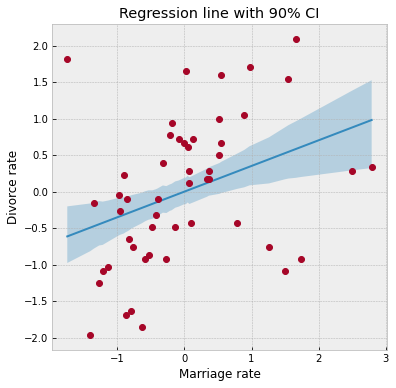

In [9]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = (
    torch.unsqueeze(samples_1["a"], -1)
    + torch.unsqueeze(samples_1["bM"], -1) * dset.MarriageScaled.values
)
mean_mu = torch.mean(posterior_mu, axis=0)
hpdi_mu = stats.hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI" 
);

We can see from the plot, that the CI broadens towards the tails where the data is relatively sparse, as can be expected.

#### <a id='Prior-Predictive-Distribution'>Prior Predictive Distribution</a>

Let us check that we have set sensible priors by sampling from the prior predictive distribution. Pyro provides a handy [Predictive](https://docs.pyro.ai/en/stable/inference_algos.html?highlight=Predictive#module-pyro.infer.predictive) utility for this purpose.

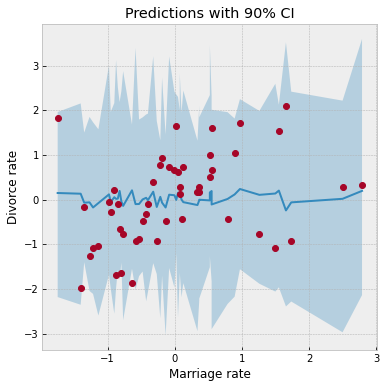

In [10]:
from pyro.infer import Predictive

prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float))[
    "obs"
]
mean_prior_pred = torch.mean(prior_predictions, axis=0)
hpdi_prior_pred = stats.hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

### <a id='Posterior-Predictive-Distribution'>Posterior Predictive Distribution</a>

Let us now look at the posterior predictive distribution to see how our predictive distribution looks with respect to the observed divorce rates. To get samples from the posterior predictive distribution, we need to run the model by substituting the latent parameters with samples from the posterior. Note that by default we generate a single prediction for each sample from the joint posterior distribution, but this can be controlled using the `num_samples` argument.

In [11]:
pyro.set_rng_seed(1)
predictive = Predictive(model, samples_1)
predictions = predictive(marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float))["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = torch.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.017195
1,Alaska,0.525918
2,Arizona,0.026437
3,Arkansas,0.550773
4,California,-0.134245


#### <a id='Predictive-Utility-With-Effect-Handlers'>Predictive Utility With Effect Handlers</a>

To remove the magic behind `Predictive`, let us see how we can use Poutine [(Effect Handlers)](https://docs.pyro.ai/en/stable/poutine.html?highlight=effect%20handler). Unlike NumPyro, where we could combine the effect handlers with the [vmap](https://github.com/google/jax#auto-vectorization-with-vmap) JAX primitive to implement our own simplified predictive utility function that can do vectorized predictions, here we use a native for-loop to show the same implementation. 

In [13]:
# pyro.set_rng_seed(102)
def predict(post_samples, model, *args, **kwargs):
    model = poutine.condition(model, post_samples)
    model_trace = poutine.trace(model).get_trace(*args, **kwargs)
    return model_trace.nodes["obs"]["value"]


def predict_fn(num_samples, samples):
    single_sample = {}
    preds = torch.empty(size=(num_samples, 50))
    for i in range(num_samples):
        single_sample = {"a": samples["a"][i], "bM": samples["bM"][i], "sigma": samples["sigma"][i]}
        preds[i] = predict(post_samples=single_sample, 
                            model=model, 
                            marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float)
                            )
    return preds

Note the use of the `condition` and `trace` effect handlers in the `predict` function. 

- The `condition` effect handler conditions the latent sample sites to certain values. In our case, we are conditioning on values from the posterior distribution returned by MCMC.
- The `trace` effect handler runs the model and records the execution trace within an `OrderedDict`. This trace object contains execution metadata that is useful for computing quantities such as the log joint density.

It should be clear now that the `predict` function simply runs the model by substituting the latent parameters with samples from the posterior (generated by the `mcmc` function) to generate predictions. Each draw from the posterior can be used to get predictions over all the 50 states. We get a `predictions_1` array of shape `(num_samples, 50)`. We can then compute the mean and 90% CI of these samples to plot the posterior predictive distribution. <strike>We note that our mean predictions match those obtained from the Predictive utility class.</strike>


In [14]:
pyro.set_rng_seed(1)
predictions_1 = predict_fn(num_samples=num_samples, samples=samples_1)

mean_pred = torch.mean(predictions_1, axis=0)
df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,-0.008658
1,Alaska,0.540367
2,Arizona,0.034646
3,Arkansas,0.553744
4,California,-0.075780


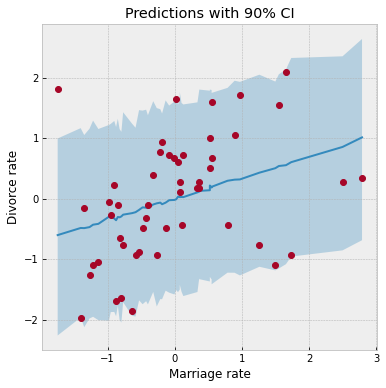

In [15]:
hpdi_pred = stats.hpdi(predictions_1, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", 
        ylabel="Divorce rate", 
        title="Predictions with 90% CI");

In [16]:
torch.allclose(predictions, predictions_1)

False

We have used the same `plot_regression` function as earlier. We notice that our CI for the predictive distribution is much broader as compared to the last plot due to the additional noise introduced by the `sigma` parameter. Most data points lie well within the 90% CI, which indicates a good fit.

#### <a id='Model-Predictive-Density'>Model Predictive Density</a>

Likewise, making use of effect-handlers, we can also compute the log likelihood for this model given the dataset, and the log posterior predictive density [[6](#References)] which is given by 
$$ log \prod_{i=1}^{n} \int p(y_i | \theta) p_{post}(\theta) d\theta 
\approx \sum_{i=1}^n log \frac{\sum_s p(\theta^{s})}{S} \\
= \sum_{i=1}^n (log \sum_s p(\theta^{s}) - log(S))
$$.

Here, $i$ indexes the observed data points $y$ and $s$ indexes the posterior samples over the latent parameters $\theta$. If the posterior predictive density for a model has a comparatively high value, it indicates that the observed data-points have higher probability under the given model.

In [17]:
def log_likelihood(params, model, *args, **kwargs):
    model = poutine.condition(model, params)
    model_trace = poutine.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace.nodes["obs"]
    return obs_node["fn"].log_prob(obs_node["value"])

def log_pred_density_helper(params, model, n, var_not_used=None, *args, **kwargs):
    single_param = {}
    tmp_tensor = torch.empty(size=(num_samples, 50))
    for i in range(n):
        if var_not_used == 'age':
            single_param = {"a": params["a"][i], "bM": params["bM"][i], "sigma": params["sigma"][i]}
        elif var_not_used == 'marriage':
            single_param = {"a": params["a"][i], "bA": params["bA"][i], "sigma": params["sigma"][i]}
        else:
            single_param = {"a": params["a"][i], "bM": params["bM"][i], "bA": params["bA"][i], "sigma": params["sigma"][i]}
        tmp_tensor[i] = log_likelihood(single_param, model, *args, **kwargs)
    return tmp_tensor



def log_pred_density(params, model, var_not_used=None, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_vals = log_pred_density_helper(params, model, n, var_not_used, *args, **kwargs)
    return (torch.logsumexp(log_lk_vals, 0) - np.log(n)).sum()

In [19]:
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(samples_1, 
                        model, 
                        var_not_used='age',
                        marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float),
                        divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
                    )
    )
)

Log posterior predictive density: -66.72371673583984


In this tutorial, we would like to emphasize that there is nothing magical about utility functions available in Pyro, and you can roll out your own inference utilities using Pyro's effect handling stack.

#### <a id='SVI'>Regression with Pyro's Stochastic Variational Inference (SVI)</a>

The objective of variational inference is to pick a family of distributions with its own parameters to approximate the true posterior distribution. Then we find the parameter values which make the approximate distribution close the the true posterior.
We carry out the steps below to define the model, extract the samples and plot the regression line. The only notable difference is that we define a `guide` to approximate the posterior. For this we one of Pyro's [autoguides](https://docs.pyro.ai/en/stable/infer.autoguide.html) - `AutoDiagonalNormal`.

In [20]:
def model_svi(marriage=None, age=None, divorce=None):
    a = pyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if age is not None:
        bA = pyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    if marriage is not None:
        bM = pyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    sigma = pyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    with pyro.plate("data", divorce.shape[0]):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

In [21]:
pyro.set_rng_seed(1)

from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal, init_to_mean

learing_rate = 1e-4

guide = AutoDiagonalNormal(model_svi)

num_iter = 7000

svi = SVI(
    model_svi,
    guide,
    optim.Adam({"lr": learing_rate}),
    loss=Trace_ELBO()
)

loss = np.empty(num_iter)

pyro.clear_param_store()
for step in range(num_iter):
    loss[step] = svi.step(
        marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float),
        divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
    )
    if step % 1000 == 0:
        print(f'step: {step:>5}, ELBO loss: {loss[step]:.2f}')

step:     0, ELBO loss: 102.63
step:  1000, ELBO loss: 87.01
step:  2000, ELBO loss: 76.31
step:  3000, ELBO loss: 75.36
step:  4000, ELBO loss: 77.44
step:  5000, ELBO loss: 73.24
step:  6000, ELBO loss: 73.90


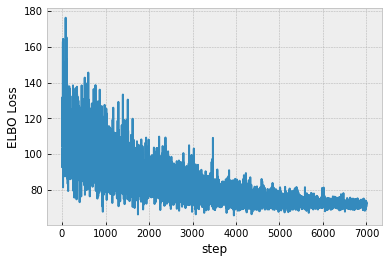

In [22]:
# Plot the loss curve
plt.plot(loss)
plt.xlabel('step')
plt.ylabel('ELBO Loss');

In [23]:
pyro.set_rng_seed(1)

posterior_svi = Predictive(model_svi, guide=guide, num_samples=num_samples)
samples_1_svi = {k: v.reshape(num_samples)
                   for k, v in posterior_svi(
                       marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float),
                       divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
                   ).items()
                   if k != "obs"}

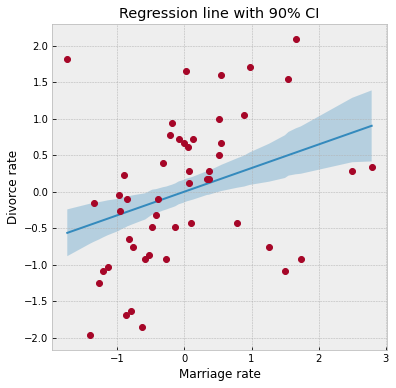

In [26]:
# Compute empirical posterior distribution over mu
posterior_mu_svi = (
    torch.unsqueeze(samples_1_svi["a"], -1)
    + torch.unsqueeze(samples_1_svi["bM"], -1) * dset.MarriageScaled.values
)
mean_mu_svi = torch.mean(posterior_mu_svi, axis=0)
hpdi_mu_svi = stats.hpdi(posterior_mu_svi, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu_svi, hpdi_mu_svi)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI" 
);

### <a id='Model-2:-Predictor---Median-Age-of-Marriage'>Model 2: Predictor - Median Age of Marriage</a>

We will now model the divorce rate as a function of the median age of marriage. The computations are mostly a reproduction of what we did for Model 1. Notice the following:

- Divorce rate is inversely related to the age of marriage. Hence states where the median age of marriage is low will likely have a higher divorce rate.
- We get a higher log likelihood as compared to Model 2, indicating that median age of marriage is likely a much better predictor of divorce rate.


In [31]:
mcmc.run(
    age=torch.tensor(dset.AgeScaled.values, dtype=torch.float), 
    divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
)
mcmc.summary()
samples_2 = mcmc.get_samples()

Sample: 100%|██████████| 2200/2200 [00:11, 195.41it/s, step size=9.35e-01, acc. prob=0.894]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.10     -0.00     -0.17      0.16   2050.64      1.00
        bA     -0.57      0.12     -0.56     -0.77     -0.39   2216.57      1.00
     sigma      0.82      0.08      0.82      0.69      0.96   1624.74      1.00

Number of divergences: 0


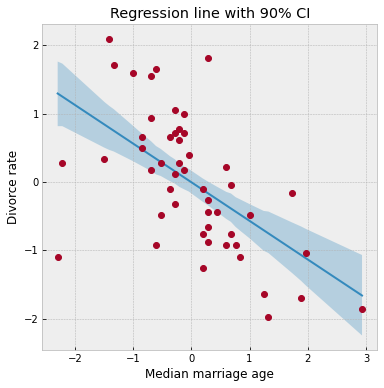

Warmup:   0%|          | 0/2200 [01:18, ?it/s]


In [32]:
posterior_mu = (
    torch.unsqueeze(samples_2["a"], -1)
    + torch.unsqueeze(samples_2["bA"], -1) * dset.AgeScaled.values
)
mean_mu = torch.mean(posterior_mu, axis=0)
hpdi_mu = stats.hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Median marriage age", 
    ylabel="Divorce rate", 
    title="Regression line with 90% CI" 
);

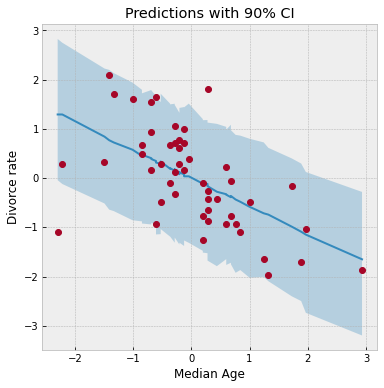

In [33]:
predictive_2 = Predictive(model, samples_2)
predictions_2 = predictive_2(age=torch.tensor(dset.AgeScaled.values, dtype=torch.float))["obs"]

mean_pred = torch.mean(predictions_2, axis=0)
hpdi_pred = stats.hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Median Age", ylabel="Divorce rate", title="Predictions with 90% CI");

In [34]:
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(samples_2, 
                        model, 
                        var_not_used='marriage',
                        age=torch.tensor(dset.AgeScaled.values, dtype=torch.float),
                        divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
                    )
    )
)

Log posterior predictive density: -59.230838775634766


### <a id='Model-3:-Predictor---Marriage-Rate-and-Median-Age-of-Marriage'>Model 3: Predictor - Marriage Rate and Median Age of Marriage</a>

Finally, we will also model divorce rate as depending on both marriage rate as well as the median age of marriage. Note that the model's posterior predictive density is similar to Model 2 which likely indicates that the marginal information from marriage rate in predicting divorce rate is low when the median age of marriage is already known.

In [37]:
mcmc.run(
    marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float), 
    age=torch.tensor(dset.AgeScaled.values, dtype=torch.float), 
    divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
)
mcmc.summary()
samples_3 = mcmc.get_samples()

Sample: 100%|██████████| 2200/2200 [00:24, 90.21it/s, step size=5.01e-01, acc. prob=0.951] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.10     -0.00     -0.16      0.16   1556.61      1.00
        bA     -0.60      0.15     -0.61     -0.84     -0.34   1490.61      1.00
        bM     -0.06      0.15     -0.06     -0.30      0.21   1320.65      1.00
     sigma      0.82      0.09      0.82      0.69      0.96   1233.32      1.00

Number of divergences: 0


In [38]:
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(samples_3, 
                        model, 
                        # var_not_used='marriage',
                        marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float),
                        age=torch.tensor(dset.AgeScaled.values, dtype=torch.float),
                        divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
                    )
    )
)

Log posterior predictive density: -59.05080032348633


### <a id='Divorce-Rate-Residuals-by-State'>Divorce Rate Residuals by State</a>

The regression plots above shows that the observed divorce rates for many states differs considerably from the mean regression line. To dig deeper into how the last model (Model 3) under-predicts or over-predicts for each of the states, we will plot the posterior predictive and residuals (`Observed divorce rate - Predicted divorce rate`) for each of the states.

In [39]:
# Predictions for Model 3
predictive_3 = Predictive(model, samples_3)
predictions_3 = predictive_3(marriage=dset.MarriageScaled.values, age=dset.AgeScaled.values)["obs"]

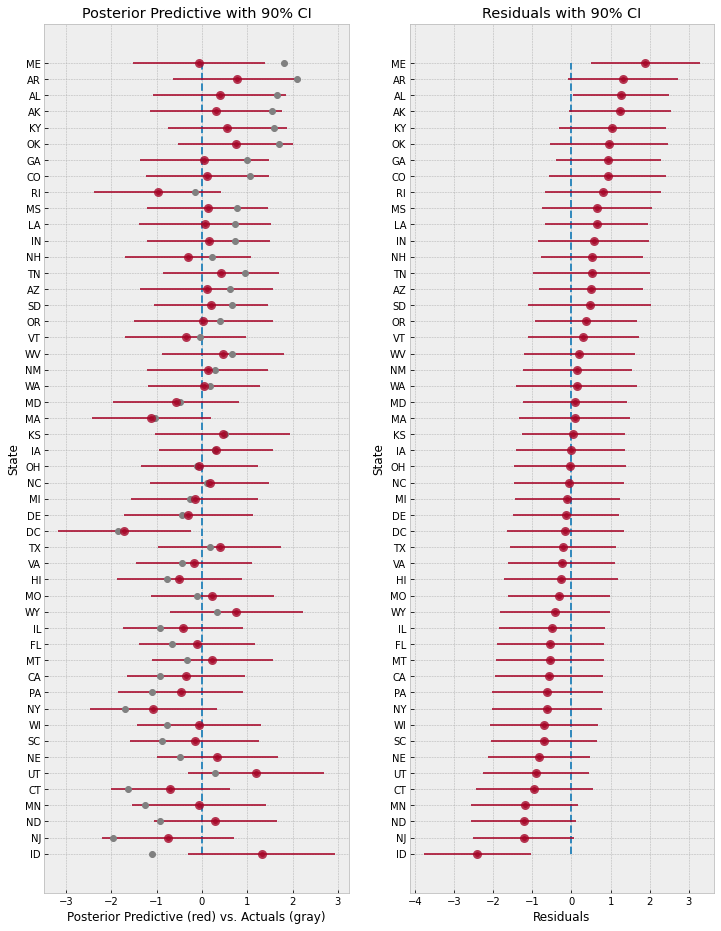

In [40]:
y = torch.arange(50)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = torch.mean(predictions_3, axis=0)
pred_hpdi = stats.hpdi(predictions_3, 0.9)
residuals_3 = torch.tensor(dset.DivorceScaled.values, dtype=torch.float) - predictions_3
residuals_mean = torch.mean(residuals_3, axis=0)
residuals_hpdi = stats.hpdi(residuals_3, 0.9)
idx = torch.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(torch.zeros(50), y, "--")
ax[0].errorbar(
    pred_mean[idx],
    y,
    xerr=pred_hpdi[1, idx] - pred_mean[idx],
    marker="o",
    ms=5,
    mew=4,
    ls="none",
    alpha=0.8,
)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker="o", ls="none", color="gray")
ax[0].set(
    xlabel="Posterior Predictive (red) vs. Actuals (gray)",
    ylabel="State",
    title="Posterior Predictive with 90% CI",
)
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10)

# Plot residuals
residuals_3 = torch.tensor(dset.DivorceScaled.values, dtype=torch.float) - predictions_3
residuals_mean = torch.mean(residuals_3, axis=0)
residuals_hpdi = stats.hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(torch.zeros(50), y, "--")
ax[1].errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
)
ax[1].set(xlabel="Residuals", ylabel="State", title="Residuals with 90% CI")
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10);

The plot on the left shows the mean predictions with 90% CI for each of the states using Model 3. The gray markers indicate the actual observed divorce rates. The right plot shows the residuals for each of the states, and both these plots are sorted by the residuals, i.e. at the bottom, we are looking at states where the model predictions are higher than the observed rates, whereas at the top, the reverse is true.

Overall, the model fit seems good because most observed data points like within a 90% CI around the mean predictions. However, notice how the model over-predicts by a large margin for states like Idaho (bottom left), and on the other end under-predicts for states like Maine (top right). This is likely indicative of other factors that we are missing out in our model that affect divorce rate across different states. Even ignoring other socio-political variables, one such factor that we have not yet modeled is the measurement noise given by `Divorce SE` in the dataset. We will explore this in the next section.


## <a id='Regression-Model-with-Measurement-Error'>Regression Model with Measurement Error</a>

Note that in our previous models, each data point influences the regression line equally. Is this well justified? We will build on the previous model to incorporate measurement error given by `Divorce SE` variable in the dataset. Incorporating measurement noise will be useful in ensuring that observations that have higher confidence (i.e. lower measurement noise) have a greater impact on the regression line. On the other hand, this will also help us better model outliers with high measurement errors. For more details on modeling errors due to measurement noise, refer to Chapter 14 of [[1](#References)].

To do this, we will reuse Model 3, with the only change that the final observed value has a measurement error given by `divorce_sd` (notice that this has to be standardized since the `divorce` variable itself has been standardized to mean 0 and std 1).

In [41]:
def model_se(marriage, age, divorce_sd, divorce=None):
    a = pyro.sample("a", dist.Normal(0.0, 0.2))
    bM = pyro.sample("bM", dist.Normal(0.0, 0.5))
    M = bM * marriage
    bA = pyro.sample("bA", dist.Normal(0.0, 0.5))
    A = bA * age
    sigma = pyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    divorce_rate = pyro.sample("divorce_rate", dist.Normal(mu, sigma))
    pyro.sample("obs", dist.Normal(divorce_rate, divorce_sd), obs=divorce)

In [42]:
# Standardize
dset["DivorceScaledSD"] = dset["Divorce SE"] / np.std(dset.Divorce.values)

In [43]:
kernel = NUTS(model_se, target_accept_prob=0.9)
mcmc = MCMC(kernel, warmup_steps=1000, num_samples=3000)
mcmc.run(
    marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float), 
    age=torch.tensor(dset.AgeScaled.values, dtype=torch.float), 
    divorce_sd=torch.tensor(dset.DivorceScaledSD, dtype=torch.float),
    divorce=torch.tensor(dset.DivorceScaled.values, dtype=torch.float)
)
mcmc.summary()
samples_4 = mcmc.get_samples()

Sample: 100%|██████████| 4000/4000 [01:23, 48.07it/s, step size=2.61e-01, acc. prob=0.933]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
               a     -0.05      0.10     -0.05     -0.22      0.09   3291.71      1.00
              bA     -0.61      0.16     -0.61     -0.88     -0.36   1730.91      1.00
              bM      0.06      0.17      0.06     -0.24      0.32   1523.00      1.00
 divorce_rate[0]      1.15      0.35      1.15      0.58      1.72   3659.84      1.00
 divorce_rate[1]      0.69      0.55      0.68     -0.27      1.54   3699.36      1.00
 divorce_rate[2]      0.43      0.32      0.42     -0.12      0.95   4414.06      1.00
 divorce_rate[3]      1.41      0.48      1.40      0.65      2.20   4827.35      1.00
 divorce_rate[4]     -0.90      0.13     -0.90     -1.13     -0.70   5523.52      1.00
 divorce_rate[5]      0.65      0.40      0.63      0.01      1.31   4126.30      1.00
 divorce_rate[6]     -1.35      0.35     -1.35     -1.93     -0.78   4726.22      1.00
 divorce_rate[7]     -0.33      0.49     -

### <a id='Effect-of-Incorporating-Measurement-Noise-on-Residuals'>Effect of Incorporating Measurement Noise on Residuals</a>

Notice that our values for the regression coefficients is very similar to Model 3. However, introducing measurement noise allows us to more closely match our predictive distribution to the observed values. We can see this if we plot the residuals as earlier. 

In [44]:
# Predictions for Model SE
predictive_4 = Predictive(model_se, samples_4)
predictions_4 = predictive_4(
    marriage=torch.tensor(dset.MarriageScaled.values, dtype=torch.float), 
    age=torch.tensor(dset.AgeScaled.values, dtype=torch.float),
    divorce_sd=torch.tensor(dset.DivorceScaledSD.values, dtype=torch.float),
    )["obs"]


Warmup:   0%|          | 0/2200 [05:17, ?it/s]


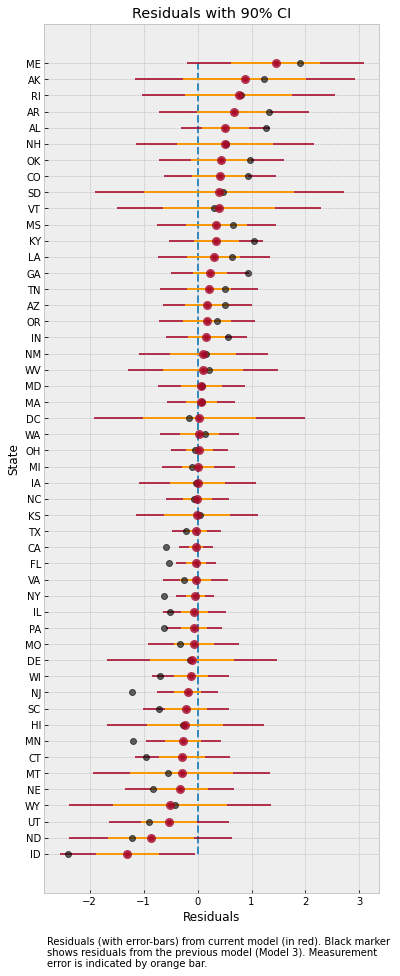

In [45]:
sd = torch.tensor(dset.DivorceScaledSD.values, dtype=torch.float)
residuals_4 = torch.tensor(dset.DivorceScaled.values, dtype=torch.float) - predictions_4
residuals_mean = torch.mean(residuals_4, axis=0)
residuals_hpdi = stats.hpdi(residuals_4, 0.9)
err = residuals_hpdi[1] - residuals_mean
idx = torch.argsort(residuals_mean)
y = torch.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 16))


# Plot Residuals
ax.plot(torch.zeros(50), y, "--")
ax.errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
)

# Plot SD
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], ls="none", color="orange", alpha=0.9)

# Plot earlier mean residual
ax.plot(
    torch.mean(torch.tensor(dset.DivorceScaled.values, dtype=torch.float) - predictions_3, 0)[idx],
    y,
    ls="none",
    marker="o",
    ms=6,
    color="black",
    alpha=0.6,
)

ax.set(xlabel="Residuals", ylabel="State", title="Residuals with 90% CI")
ax.set_yticks(y)
ax.set_yticklabels(dset.Loc.values[idx], fontsize=10)
ax.text(
    -2.8,
    -7,
    "Residuals (with error-bars) from current model (in red). "
    "Black marker \nshows residuals from the previous model (Model 3). "
    "Measurement \nerror is indicated by orange bar.",
);

The plot above shows the residuals for each of the states, along with the measurement noise given by inner error bar. The gray dots are the mean residuals from our earlier Model 3. Notice how having an additional degree of freedom to model the measurement noise has shrunk the residuals. In particular, for Idaho and Maine, our predictions are now much closer to the observed values after incorporating measurement noise in the model.

To better see how measurement noise affects the movement of the regression line, let us plot the residuals with respect to the measurement noise.


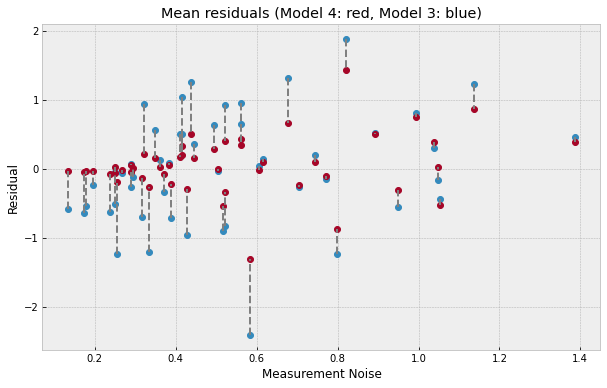

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = torch.tensor(dset.DivorceScaledSD.values, dtype=torch.float)
y1 = torch.mean(residuals_3, 0)
y2 = torch.mean(residuals_4, 0)
ax.plot(x, y1, ls="none", marker="o")
ax.plot(x, y2, ls="none", marker="o")
for i, (j, k) in enumerate(zip(y1, y2)):
    ax.plot([x[i], x[i]], [j, k], "--", color="gray")

ax.set(
    xlabel="Measurement Noise",
    ylabel="Residual",
    title="Mean residuals (Model 4: red, Model 3: blue)",
);

The plot above shows what has happened in more detail - the regression line itself has moved to ensure a better fit for observations with low measurement noise (left of the plot) where the residuals have shrunk very close to 0. That is to say that data points with low measurement error have a concomitantly higher contribution in determining the regression line. On the other hand, for states with high measurement error (right of the plot), incorporating measurement noise allows us to move our posterior distribution mass closer to the observations resulting in a shrinkage of residuals as well.

## <a id='References'>References<a/>

1. McElreath, R. (2016). Statistical Rethinking: A Bayesian Course with Examples in R and Stan CRC Press.
2. Stan Development Team. [Stan User's Guide](https://mc-stan.org/docs/2_19/stan-users-guide/index.html)
3. Goodman, N.D., and StuhlMueller, A. (2014). [The Design and Implementation of Probabilistic Programming Languages](http://dippl.org/)
4. Pyro Development Team. [Poutine: A Guide to Programming with Effect Handlers in Pyro](http://pyro.ai/examples/effect_handlers.html)
5. Hoffman, M.D., Gelman, A. (2011). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.
6. Betancourt, M. (2017). A Conceptual Introduction to Hamiltonian Monte Carlo.
7. JAX Development Team (2018). [Composable transformations of Python+NumPy programs: differentiate, vectorize, JIT to GPU/TPU, and more](https://github.com/google/jax)
8. Gelman, A., Hwang, J., and Vehtari A. [Understanding predictive information criteria for Bayesian models](https://arxiv.org/pdf/1307.5928.pdf)